# Analyzing neuropil signals in the mice
* 10/18/23 setup based on `Neuropil_analysis_single_exp.ipynb`

In [1]:
import sys, os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from os.path import join
import pandas as pd
import scipy.signal as signal
import numpy as np

sys.path.append('/home/gergely/code/sleep/base/')

from suite2p_class import Suite2p
from mouse_class import Mouse
from eeg_class import eegData
from behavior_class import behaviorData

def freq_calc(data: pd.Series, fs: int=10):
    """data: npil_eeg data"""
    frequencies, psd = signal.welch(data, fs=fs, detrend='linear')    
    return frequencies, psd

In [4]:
sima_folders = [
    '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima'
                ]

gcs = [
    '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima'
                
       ]

mcs = [
    '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima',
       ]

In [4]:
results = {}

for sima_folder in sima_folders:
    sima_dict = {}
    file_name = join(sima_folder, 'eeg', 'velo_eeg.csv' )
    eeg_velo = eegData.load_processed_velocity_eeg(file_name = file_name)
    eeg_velo['mobile_immobile'] = behaviorData.define_immobility(eeg_velo['filtered velo'])
    df = eegData.brain_state_filter(velo_eeg_df=eeg_velo,
                             states=['awake_mobile', 'awake_immobile', 'NREM', 'REM', 'other'])
    s2p_folder = join(sima_folder, 'suite2p')
    
    cells = Suite2p.true_cells(s2p_folder)    
    mean_cellF = pd.DataFrame(cells.mean(axis=0))    
    
    awake_cell = pd.Series(mean_cellF.loc[df['awake_immobile'],0])
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    sima_dict['awake_cell'] = {'freq': awake_cell_freq,
                                            'psd': awake_cell_psd}
       
    nrem_cell = pd.Series(mean_cellF.loc[df['NREM'],0])    
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    sima_dict['nrem_cell'] = {'freq': nrem_cell_freq,
                                            'psd': nrem_cell_psd}
    
    npil = Suite2p.true_npil(s2p_folder)
    mean_npilF = pd.DataFrame(npil.mean(axis=0))
    
    awake_immobile_npil = pd.Series(mean_npilF.loc[df['awake_immobile'],0])
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    sima_dict['awake_immobile_npil'] = {'freq': awake_immobile_npil_freq,
                                         'psd': awake_immobile_npil_psd}
    
    nrem_npil = pd.Series(mean_npilF.loc[df['NREM'],0])
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    sima_dict['nrem_npil'] = {'freq': nrem_npil_freq,
                                         'psd': nrem_npil_psd}
    results[sima_folder] = sima_dict

No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
Found combined folder
Found combined folder
Found combined folder
Found combined folder
Found combined folder
Found combined folder


In [90]:
results_df = pd.DataFrame(results)
results_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
nrem_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
awake_immobile_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
nrem_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."


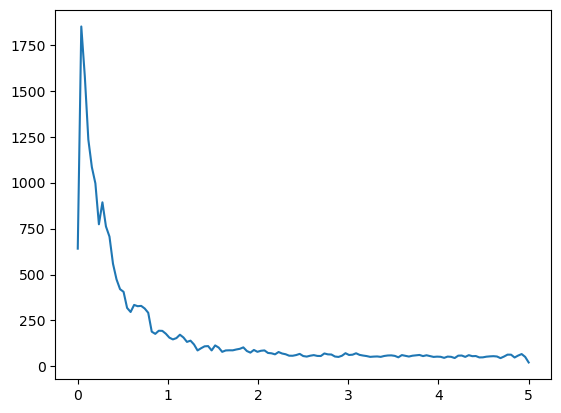

In [113]:
df = results_df.T.reset_index()
plt.plot(df.iloc[1]['awake_cell']['freq'], df.iloc[1,:]['awake_cell']['psd'])

In [5]:
cell_results = {}
npil_results = {}

for sima_folder in sima_folders:
##### Data loading and setup
    cell_dict = {}
    npil_dict = {}
    file_name = join(sima_folder, 'eeg', 'velo_eeg.csv' )
    eeg_velo = eegData.load_processed_velocity_eeg(file_name = file_name)
    eeg_velo['mobile_immobile'] = behaviorData.define_immobility(eeg_velo['filtered velo'])
    df = eegData.brain_state_filter(velo_eeg_df=eeg_velo,
                             states=['awake_mobile', 'awake_immobile', 'NREM', 'REM', 'other'])
    s2p_folder = join(sima_folder, 'suite2p')

##### Cell calculation
    cells = Suite2p.true_cells(s2p_folder)    
    mean_cellF = pd.DataFrame(cells.mean(axis=0))    
    
    awake_cell = pd.Series(mean_cellF.loc[df['awake_immobile'],0])
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    cell_dict['cell_awake_freq'] = {'freq': awake_cell_freq}
    cell_dict['cell_awake_psd'] = {'psd': awake_cell_psd}
       
    nrem_cell = pd.Series(mean_cellF.loc[df['NREM'],0])    
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    cell_dict['cell_nrem_freq'] = {'freq': nrem_cell_freq}
    cell_dict['cell_nrem_psd'] = {'psd': nrem_cell_psd}
    
    cell_results[sima_folder] = cell_dict

##### Neuropil calculation

    npil = Suite2p.true_npil(s2p_folder)
    mean_npilF = pd.DataFrame(npil.mean(axis=0))
    
    awake_immobile_npil = pd.Series(mean_npilF.loc[df['awake_immobile'],0])
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    npil_dict['npil_awake_freq'] = {'freq': awake_immobile_npil_freq},
    npil_dict['npil_awake_psd'] = {'psd': awake_immobile_npil_psd}
    
    nrem_npil = pd.Series(mean_npilF.loc[df['NREM'],0])
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    npil_dict['npil_nrem_freq'] = {'freq': nrem_npil_freq}
    npil_dict['npil_nrem_psd'] = {'psd': nrem_npil_psd}
    npil_results[sima_folder] = npil_dict

No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
No combined folder found, using plane0
Found combined folder
Found combined folder
Found combined folder
Found combined folder
Found combined folder
Found combined folder


In [93]:
cell_results_df = pd.DataFrame(cell_results)
npil_results_df = pd.DataFrame(npil_results)

In [95]:
cell_df = cell_results_df.copy()
cell_awake_arrs = []
cell_nrem_arrs = []
for i in range(len(cell_df.columns)):
    cell_awake_arrs.append(cell_df.loc['cell_awake_psd'][i]['psd'])
    cell_nrem_arrs.append(cell_df.loc['cell_nrem_psd'][i]['psd'])
cell_awake_mean_freq = np.mean(cell_awake_arrs, axis=0)
cell_nrem_mean_freq = np.mean(cell_nrem_arrs, axis=0)

npil_df = npil_results_df.copy()
npil_awake_arrs = []
npil_nrem_arrs = []
for i in range(len(npil_df.columns)):
    npil_awake_arrs.append(npil_df.loc['npil_awake_psd'][i]['psd'])
    npil_nrem_arrs.append(npil_df.loc['npil_nrem_psd'][i]['psd'])
npil_awake_mean_freq = np.mean(npil_awake_arrs, axis=0)
npil_nrem_mean_freq = np.mean(npil_nrem_arrs, axis=0)


In [113]:
npil_df.loc["npil_awake_freq"][0][0]["freq"]

array([0.       , 0.0390625, 0.078125 , 0.1171875, 0.15625  , 0.1953125,
       0.234375 , 0.2734375, 0.3125   , 0.3515625, 0.390625 , 0.4296875,
       0.46875  , 0.5078125, 0.546875 , 0.5859375, 0.625    , 0.6640625,
       0.703125 , 0.7421875, 0.78125  , 0.8203125, 0.859375 , 0.8984375,
       0.9375   , 0.9765625, 1.015625 , 1.0546875, 1.09375  , 1.1328125,
       1.171875 , 1.2109375, 1.25     , 1.2890625, 1.328125 , 1.3671875,
       1.40625  , 1.4453125, 1.484375 , 1.5234375, 1.5625   , 1.6015625,
       1.640625 , 1.6796875, 1.71875  , 1.7578125, 1.796875 , 1.8359375,
       1.875    , 1.9140625, 1.953125 , 1.9921875, 2.03125  , 2.0703125,
       2.109375 , 2.1484375, 2.1875   , 2.2265625, 2.265625 , 2.3046875,
       2.34375  , 2.3828125, 2.421875 , 2.4609375, 2.5      , 2.5390625,
       2.578125 , 2.6171875, 2.65625  , 2.6953125, 2.734375 , 2.7734375,
       2.8125   , 2.8515625, 2.890625 , 2.9296875, 2.96875  , 3.0078125,
       3.046875 , 3.0859375, 3.125    , 3.1640625, 

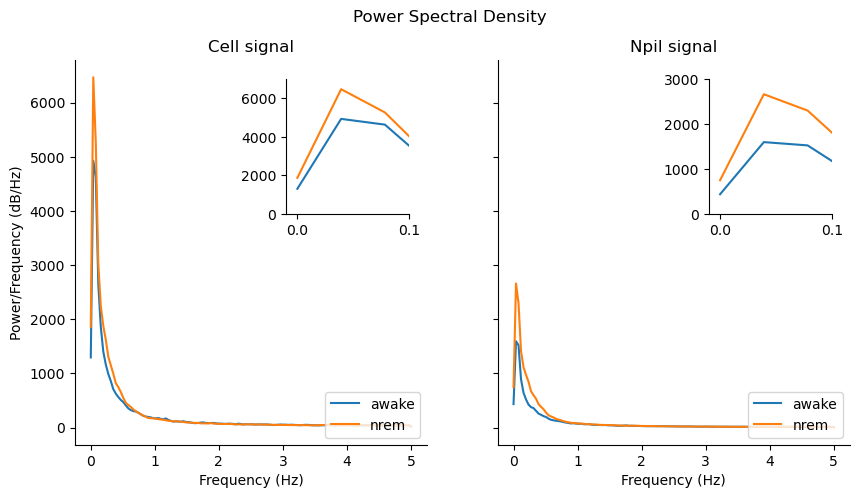

In [121]:
# Your data and calculations here

# Create the main plot
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density")
ax[0].plot(
    cell_df.loc["cell_awake_freq"][0]["freq"], cell_awake_mean_freq, label="awake"
)
ax[0].plot(cell_df.loc["cell_nrem_freq"][0]["freq"], cell_nrem_mean_freq, label="nrem")
ax[0].legend(loc="lower right")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Cell signal")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Power/Frequency (dB/Hz)")

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins1 = ax[0].inset_axes(bounds=bounds)
axins1.spines["top"].set_visible(False)
axins1.spines["right"].set_visible(False)

# Plot data in the inset
axins1.plot(
    cell_df.loc["cell_awake_freq"][0]["freq"], cell_awake_mean_freq, label="awake"
)
axins1.plot(cell_df.loc["cell_nrem_freq"][0]["freq"], cell_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins1.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
axins1.set_ylim(0, 7000)  # Modify these values to specify the desired limits

# TODO: hunt down why the indexing is different for the npil data!!!
ax[1].plot(
    npil_df.loc["npil_awake_freq"][0][0]["freq"], npil_awake_mean_freq, label="awake"
)
ax[1].plot(npil_df.loc["npil_nrem_freq"][0]["freq"], npil_nrem_mean_freq, label="nrem")
ax[1].set_title("Npil signal")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].legend(loc="lower right")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins2 = ax[1].inset_axes(bounds=bounds)
axins2.spines["top"].set_visible(False)
axins2.spines["right"].set_visible(False)

# Plot data in the inset
axins2.plot(
    npil_df.loc["npil_awake_freq"][0][0]["freq"], npil_awake_mean_freq, label="awake"
)
axins2.plot(npil_df.loc["npil_nrem_freq"][0]["freq"], npil_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins2.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
axins2.set_ylim(0, 3000)  # Modify these values to specify the desired limits

plt.show()